Install libraries

In [1]:
!pip install sentinelsat
!pip install geopandas
!pip install rasterio

     |████████████████████████████████| 931kB 8.1MB/s 
     |████████████████████████████████| 14.7MB 308kB/s 
     |████████████████████████████████| 10.4MB 59.6MB/s 
     |████████████████████████████████| 18.1MB 241kB/s 


Import libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from sentinelsat import SentinelAPI
import folium
import shapely
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon
from shapely.geometry import shape
from shapely.geometry import box
import urllib.request as request
import json
from datetime import datetime
import zipfile
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
import os

Extract Geometries

In [0]:
max_records=10
first_record = 18290
current_record = first_record
names = []
countries = []
latitudes = []
longitudes = []
geometries = []
while len(names) < max_records:
  water_url = f'https://water.blue-dot-observatory.com/api/waterbodies/{current_record}/index.html'
  try:
    water_body_data = json.loads(request.urlopen(water_url).read().decode())
    names.append(water_body_data['properties']['name'])
    countries.append(water_body_data['properties']['country'])
    latitudes.append(water_body_data['properties']['lat'])
    longitudes.append(water_body_data['properties']['long'])
    geometries.append(water_body_data['nominal_outline']['geometry'])
  except:
    pass
  current_record += 1

Create Dataframe

In [0]:
water_bodies = pd.DataFrame({'Name':names,
                             'Country':countries,
                             'Latitude':latitudes,
                             'Longitude':longitudes,
                             'Geometry':geometries})

In [5]:
water_bodies

Name  ...                                           Geometry
0                    Lake Travis  ...  {'coordinates': [[[[-98.0217194, 30.3745221], ...
1                 Lake Arlington  ...  {'coordinates': [[[-97.2335181, 32.6921516], [...
2                  Lake Buchanan  ...  {'coordinates': [[[-98.4783375, 30.7971736], [...
3             Walter E Long Lake  ...  {'coordinates': [[[-97.6199675, 30.303003], [-...
4        Cooling Water Reservoir  ...  {'coordinates': [[[-96.080274, 28.7517011], [-...
5                  Lake Tawakoni  ...  {'coordinates': [[[-96.1319487, 32.8534733], [...
6             Eagle Mountain Dam  ...  {'coordinates': [[[-97.529902, 32.9085778], [-...
7                    Twin Buttes  ...  {'coordinates': [[[[-100.6083856, 31.3296567],...
8  Peacock Site 1-A Tailings Dam  ...  {'coordinates': [[[-94.6819945, 32.9681979], [...
9                 Somerville Dam  ...  {'coordinates': [[[[-96.5679466, 30.2964676], ...

[10 rows x 5 columns]

Plot Map

In [0]:
my_map = folium.Map(location = [30.442056, -98.004388], zoom_start=11)

In [7]:
for water_body in water_bodies['Geometry']:
  folium.GeoJson(shape(water_body)).add_to(my_map)
my_map

Read login credentials

In [0]:
with open('/content/drive/My Drive/Sentinel Hub Credentials/login_info.txt') as file:
  credentials = file.readlines()
  credentials = [credential.strip() for credential in credentials]

Download Satellite Images

In [0]:
api = SentinelAPI(credentials[0], credentials[1], 'https://scihub.copernicus.eu/dhus')

In [0]:
today = datetime.today().strftime('%Y%m%d')

In [0]:
water_body_geometry = water_bodies.iloc[0]['Geometry']

In [0]:
water_body_shape = shape(water_body_geometry)
shape_simplified = water_body_shape.simplify(1)

In [0]:
shape_simplified = box(water_body_shape.bounds[0], water_body_shape.bounds[1], water_body_shape.bounds[2], water_body_shape.bounds[3])

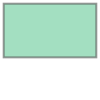

In [14]:
shape_simplified

In [20]:
results = api.query(shape_simplified, date = ('20140101', today), platformname = 'Sentinel-2', processinglevel = 'Level-1C', cloudcoverpercentage = (0,5))
results_gdf = api.to_geodataframe(results).sort_values(['cloudcoverpercentage'], ascending=True)
uuid = results_gdf.iloc[0]['uuid']
filename = '/content/' + results_gdf.iloc[0]['title'] + '.zip'
data = api.download(uuid)

Querying products: 100%|██████████| 144/144 [00:00<00:00, 149.83 products/s]
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [0]:
with zipfile.ZipFile(filename, 'r') as zip_ref:
  zip_ref.extractall('/content/drive/My Drive/Satellite Data/')
folder = os.listdir('/content/drive/My Drive/Satellite Data/' + data['title'] + '.SAFE/GRANULE/')[0]
directory = '/content/drive/My Drive/Satellite Data/' + data['title'] + '.SAFE/GRANULE/' + folder + '/IMG_DATA/'

In [22]:
folium.GeoJson(shapely.wkt.loads((data['footprint']))).add_to(my_map)
my_map

In [0]:
os.remove(filename)

In [0]:
for f in os.listdir(directory):
  if '_TC' in f:
    true_color = rio.open(directory + f)
    fname = directory + f

In [0]:
for f in os.listdir(directory):
  if '_B02' in f:
    band_2 = rio.open(directory + f)
  elif '_B03' in f:
    band_3 = rio.open(directory + f)
  elif '_B04' in f:
    band_4 = rio.open(directory + f)

In [0]:
with rio.open('RGB.tiff','w',driver='Gtiff', width=band_4.width, height=band_4.height, 
              count=3,crs=band_4.crs,transform=band_4.transform, dtype=band_4.dtypes[0]) as rgb:
    rgb.write(band_2.read(1),1) 
    rgb.write(band_3.read(1),2) 
    rgb.write(band_4.read(1),3) 
    rgb.close()

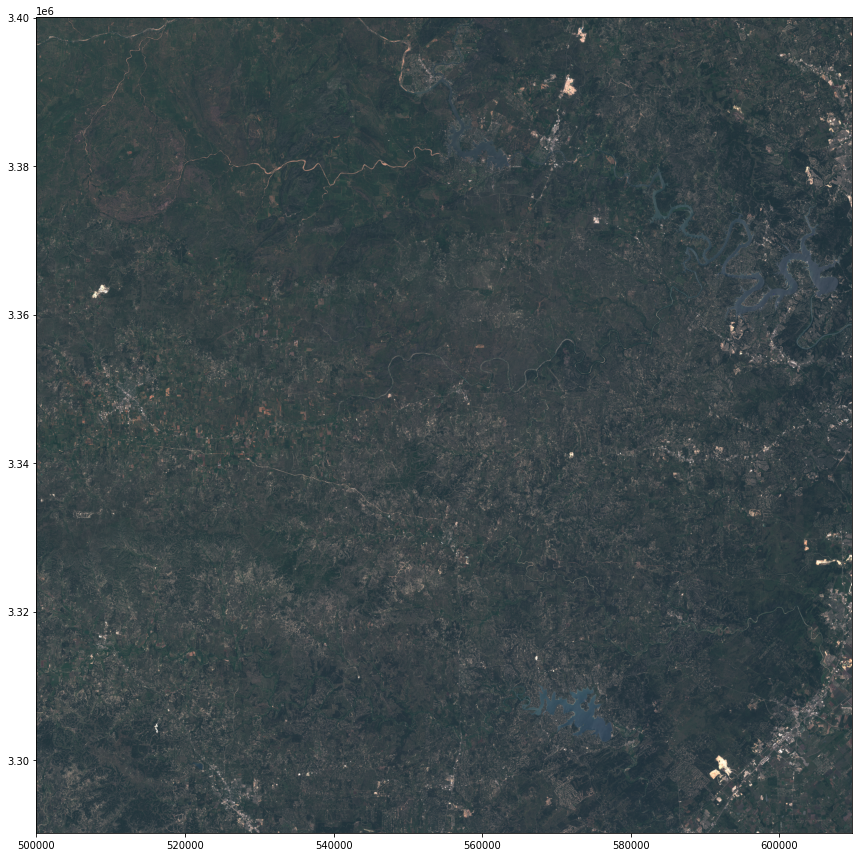

In [25]:
plt.figure(figsize=(15,15))
show(true_color)

In [0]:
minx, miny = -98.2571703, 30.3577993
maxx, maxy = -97.8719835, 30.5810474
bbox = box(minx, miny, maxx, maxy)

In [66]:
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
print(geo)

                                            geometry
0  POLYGON ((-97.87198 30.35780, -97.87198 30.581...


/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [0]:
src = rasterio.open('/content/RGB.tiff')

In [69]:
# Project the Polygon into same CRS as the grid
geo = geo.to_crs(crs=src.crs.data)

# Print crs
geo.crs

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<Projected CRS: EPSG:32614>
Name: WGS 84 / UTM zone 14N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 102°W to 96°W - by country
- bounds: (-102.0, 0.0, -96.0, 84.0)
Coordinate Operation:
- name: UTM zone 14N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [0]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [71]:
coords = getFeatures(geo)
print(coords)

[{'type': 'Polygon', 'coordinates': [[[608405.6357454355, 3358972.860974127], [608158.6021092285, 3383714.6797456937], [571224.129600805, 3383407.870148308], [571386.7872278213, 3358667.38035143], [608405.6357454355, 3358972.860974127]]]}]


In [0]:
from rasterio.mask import mask

In [0]:
out_img, out_transform = mask(dataset=src, shapes=coords, crop=True)

In [75]:
out_meta = src.meta.copy()
print(out_meta)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 3, 'crs': CRS.from_epsg(32614), 'transform': Affine(10.0, 0.0, 499980.0,
       0.0, -10.0, 3400020.0)}


In [76]:
epsg_code = int(src.crs.data['init'][5:])
print(epsg_code)

32614


In [0]:
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 #"crs": pycrs.parser.from_epsg_code(epsg_code).to_proj4()
                 }
                         )

In [78]:
!pip install pycrs

In [0]:
import pycrs

In [0]:
with rasterio.open('/content/output.tiff', "w", **out_meta) as dest:
        dest.write(out_img)

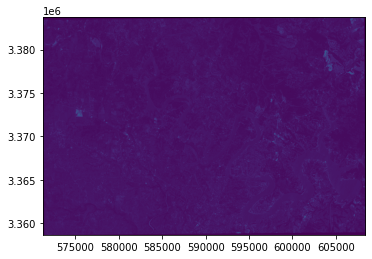

In [96]:
clipped = rasterio.open('/content/output.tiff')
show((clipped, 3))

In [98]:
img = Image.open('/content/output.tiff')

UnidentifiedImageError: ignored